# Multi-strain modeling

The goal of this exercise is to provide an introduction to multi-strain metabolic modeling of the E. coli species. The following is largely take from

"Monk, J. M., Charusanti, P., Aziz, R. K., Lerman, J. a, Premyodhin, N., Orth, J. D., … Palsson, B. Ø. (2013). Genome-scale metabolic reconstructions of multiple Escherichia coli strains highlight strain-specific adaptations to nutritional environments. Proceedings of the National Academy of Sciences, 110(50), 20338–20343. http://doi.org/10.1073/pnas.1307797110" 

In [23]:
import pandas
import glob
import cobra

from IPython.display import Image 
import pydotplus
from sklearn.externals.six import StringIO  
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz 

import seaborn as sns

from qbio_resources.multistrain_info import carbon_sources,  strain_classification
%matplotlib inline

----
## A) Simulating growth w/ multi strain models

### 1) Using the 46 models, simulate growth on the 78 carbon containing nutrients in `carbon_sources` and output all predicted growth rates.

The carbon sources are listed below. These are all of the metabolites that show variable growth capabilities among the strains.

In [2]:
print(carbon_sources)

['EX_12ppd__S_e', 'EX_14glucan_e', 'EX_3hcinnm_e', 'EX_3hpppn_e', 'EX_5dglcn_e', 'LalaDgluMdap_e', 'EX_acac_e', 'EX_acgal_e', 'EX_acgal1p_e', 'EX_akg_e', 'all__D_e', 'EX_alltn_e', 'EX_arab__L_e', 'EX_ascb__L_e', 'EX_but_e', 'EX_butso3_e', 'chol_e', 'EX_csn_e', 'EX_cys__D_e', 'EX_etha_e', 'EX_fald_e', 'EX_fe3dcit_e', 'frulys_e', 'EX_fruur_e', 'EX_fuc__L_e', 'EX_g1p_e', 'EX_gal_e', 'EX_gal_bD_e', 'gal1p_e', 'EX_galct__D_e', 'EX_galctn__D_e', 'EX_galctn__L_e', 'EX_galt_e', 'galur_e', 'EX_glcur_e', 'EX_glcur1p_e', 'EX_glyclt_e', 'EX_idon__L_e', 'lyx__L_e', 'EX_malt_e', 'EX_malthx_e', 'EX_maltpt_e', 'EX_malttr_e', 'maltttr_e', 'EX_manglyc_e', 'EX_melib_e', 'EX_orot_e', 'EX_pacald_e', 'EX_peamn_e', 'ppa_e', 'EX_ppal_e', 'EX_pppn_e', 'EX_psclys_e', 'EX_r5p_e', 'EX_rib__D_e', 'rmn_e', 'EX_sbt__D_e', 'EX_sucr_e', 'EX_tartr__D_e', 'EX_trp__L_e', 'EX_uacgam_e', 'udpacgal_e', 'EX_udpg_e', 'EX_udpgal_e', 'EX_udpglcur_e', 'EX_ura_e', 'EX_xan_e', 'xyl__D_e', 'EX_xylu__L_e', 'EX_4hphac_e', 'EX_4hthr_e

**Hints:**
  
1) The models are contained in the `multi_strain_models` directory and their filepaths can be listed using `glob`
 - Each model can be loded from the filepath in this list using `cobra.io.load_json_model(filepath)`

In [3]:
print(glob.glob('../qbio_resources/multi_strain_models/*.json'))

['../qbio_resources/multi_strain_models/iEcHS_1320.json', '../qbio_resources/multi_strain_models/iECSE_1348.json', '../qbio_resources/multi_strain_models/iECBD_1354.json', '../qbio_resources/multi_strain_models/iEKO11_1354.json', '../qbio_resources/multi_strain_models/iEcSMS35_1347.json', '../qbio_resources/multi_strain_models/iZ_1308.json', '../qbio_resources/multi_strain_models/iECs_1301.json', '../qbio_resources/multi_strain_models/iECSP_1301.json', '../qbio_resources/multi_strain_models/iUTI89_1310.json', '../qbio_resources/multi_strain_models/iECH74115_1262.json', '../qbio_resources/multi_strain_models/iECDH10B_1368.json', '../qbio_resources/multi_strain_models/iWFL_1372.json', '../qbio_resources/multi_strain_models/iECO103_1326.json', '../qbio_resources/multi_strain_models/iECP_1309.json', '../qbio_resources/multi_strain_models/iECD_1391.json', '../qbio_resources/multi_strain_models/iECO111_1330.json', '../qbio_resources/multi_strain_models/iG2583_1286.json', '../qbio_resources/m

2) The most conventient way to output the results is as a `pandas.DataFrame` (table) 
  - You can then update the values in the table by row and column name using the following

In [4]:
# Initialize an empty DataFram
df = pandas.DataFrame()

# Add new value
df.loc['Row 0', 'Column 0'] = 5
df.loc['Row 1', 'Column 0'] = 10
df.loc['Row 1', 'Column 1'] = 2
df

,Column 0,Column 1
Row 0,5.0,NaN
Row 1,10.0,2.0


3) When optimizing the model, it is quicker to use `slim_optimize`. This will return only the growth rate of the simulation

In [5]:
# Load model
iml = cobra.io.load_json_model('../qbio_resources/iML1515.json')

# Change carbon source
iml.reactions.EX_glc__D_e.lower_bound = 0
iml.reactions.EX_ac_e.lower_bound = -10
print(iml.slim_optimize())

0.21009920466530235


4) Do not forget to set the lower bound of the exchange reaction **back to zero** after simulating!

In [8]:
df = pandas.DataFrame()
for m in glob.glob('../qbio_resources/multi_strain_models/*.json'):
    model = cobra.io.load_json_model(m)
    model.reactions.EX_glc__D_e.lower_bound = 0
    print(model.id, model.name)
    for r_id in carbon_sources:
        if r_id not in model.reactions:
            continue
        r = model.reactions.get_by_id(r_id)

        r.lower_bound = -10
        df.loc[r.id, model.id] = model.slim_optimize()
        r.lower_bound = 0

iEcHS_1320 Escherichia coli HS
iECSE_1348 Escherichia coli SE11
iECBD_1354 Escherichia coli 'BL21-Gold(DE3)pLysS AG'
iEKO11_1354 Escherichia coli KO11FL
iEcSMS35_1347 Escherichia coli SMS-3-5
iZ_1308 Escherichia coli O157:H7 str. EDL933
iECs_1301 Escherichia coli O157:H7 str. Sakai
iECSP_1301 Escherichia coli O157:H7 str. TW14359
iUTI89_1310 Escherichia coli UTI89
iECH74115_1262 Escherichia coli O157:H7 str. EC4115
iECDH10B_1368 Escherichia coli str. K-12 substr. DH10B
iWFL_1372 Escherichia coli W
iECO103_1326 Escherichia coli O103:H2 str. 12009
iECP_1309 Escherichia coli 536
iECD_1391 Escherichia coli BL21(DE3)
iECO111_1330 Escherichia coli O111:H- str. 11128
iG2583_1286 Escherichia coli O55:H7 str. CB9615
iECED1_1282 Escherichia coli ED1a
iBWG_1329 Escherichia coli BW2952
iECW_1372 Escherichia coli W
iJO1366 Escherichia coli str. K-12 substr. MG1655
iLF82_1304 Escherichia coli LF82
iEC042_1314 Escherichia coli 042
iECIAI1_1343 Escherichia coli IAI1
iECS88_1305 Escherichia coli S88
iE

### 2) Process the dataframe by removing `nan` values and applying growth threshold

## B) Visualizing the results

In [11]:
df = pandas.read_csv('../ecoli_growth_support.csv', index_col=0)

In [13]:
test_df = df.copy()
test_df.fillna(0, inplace=True)

In [14]:
test_df[test_df < .1] = 0
test_df[test_df >= .1] = 1
test_df = test_df.T

In [17]:
map_dict = {'Commensal': 0, 'ExPec': 1, 'InPec': 2}
targets = []
for i in test_df.index:
    targets.append(map_dict[strain_classification[i]])

In [20]:
color_dict = {}
map_dict = {'Commensal': 'r', 'ExPec': 'b', 'InPec': 'g'}
for strain in strain_classification:
    color_dict[strain] =  map_dict[strain_classification[strain]]
row_colors = test_df.index.map(color_dict)

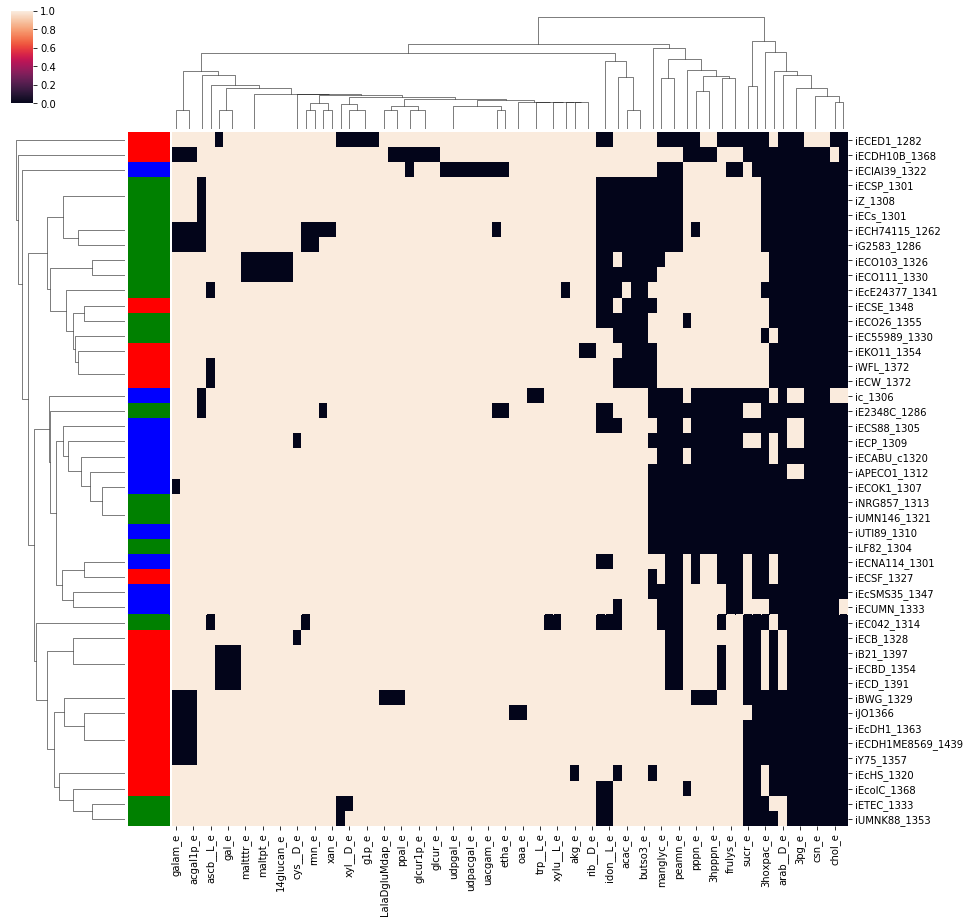

In [21]:
sns.clustermap(test_df,  figsize=(15, 15), row_colors=row_colors)

## C) Machine learning to distinguish strains

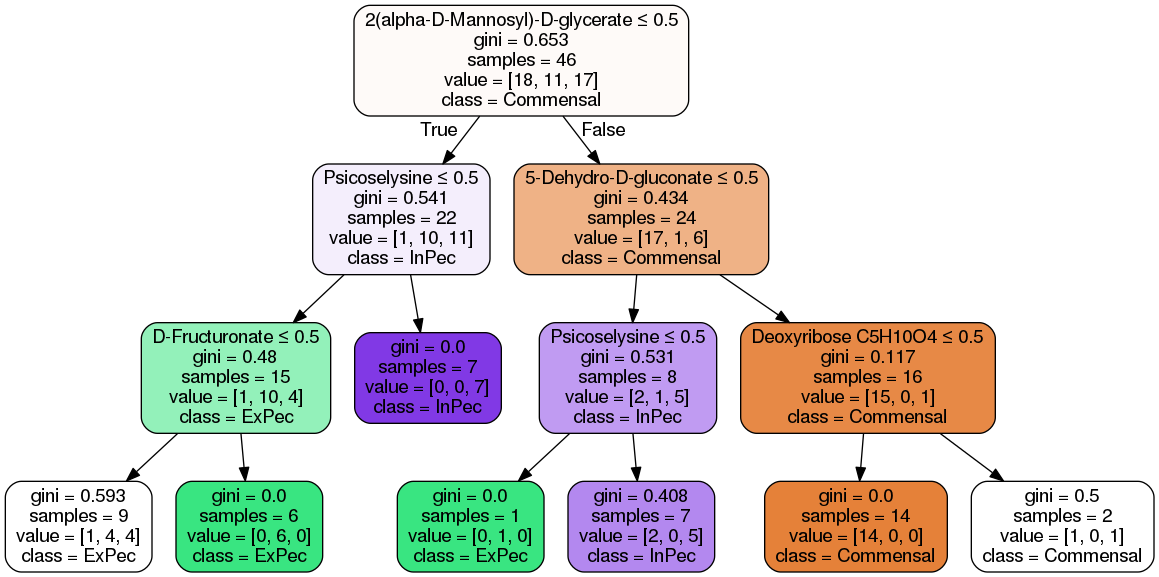

In [24]:
y = targets
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(test_df, y)

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=[model.metabolites.get_by_id(i).name for i in test_df.columns],
                class_names = list(map_dict.keys())) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())